In [1]:
import os
import shutil
import math
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, EfficientNetV2B0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EfficientNetV2B0

In [11]:
train_dir = "C:/Users/HP/Documents/MACHINE LEARNING/Bird Species/Bird Species Dataset-AUGMENTED"
val_dir = "C:/Users/HP/Documents/MACHINE LEARNING/Bird Species/Bird Species Dataset-SPLIT/validation"
test_dir = "C:/Users/HP/Documents/MACHINE LEARNING/Bird Species/Bird Species Dataset-SPLIT/test"

In [12]:
image_size = (224, 224)
batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6000 images belonging to 6 classes.
Found 118 images belonging to 6 classes.
Found 128 images belonging to 6 classes.


In [13]:
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3), include_preprocessing=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(train_data.class_indices), activation='softmax')(x)

In [14]:
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [15]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]']       

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
188/188 [==============================] - 80s 395ms/step - loss: 1.6434 - accuracy: 0.3687 - val_loss: 1.2331 - val_accuracy: 0.8390
Epoch 2/15
188/188 [==============================] - 78s 417ms/step - loss: 1.2267 - accuracy: 0.6567 - val_loss: 0.8481 - val_accuracy: 0.8898
Epoch 3/15
188/188 [==============================] - 70s 370ms/step - loss: 0.9102 - accuracy: 0.8228 - val_loss: 0.5827 - val_accuracy: 0.9576
Epoch 4/15
188/188 [==============================] - 71s 375ms/step - loss: 0.6787 - accuracy: 0.8930 - val_loss: 0.4076 - val_accuracy: 0.9746
Epoch 5/15
188/188 [==============================] - 72s 383ms/step - loss: 0.5178 - accuracy: 0.9270 - val_loss: 0.2950 - val_accuracy: 0.9831
Epoch 6/15
188/188 [==============================] - 66s 349ms/step - loss: 0.4091 - accuracy: 0.9448 - val_loss: 0.2213 - val_accuracy: 0.9831
Epoch 7/15
188/188 [==============================] - 65s 344ms/step - loss: 0.3336 - accuracy: 0.9562 - val_loss: 0.1722 - val_ac

In [18]:
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print(f"\nAkurasi model pada data test: {test_acc:.2f}")

4/4 - 1s - loss: 0.0426 - accuracy: 1.0000 - 1s/epoch - 359ms/step

Akurasi model pada data test: 1.00


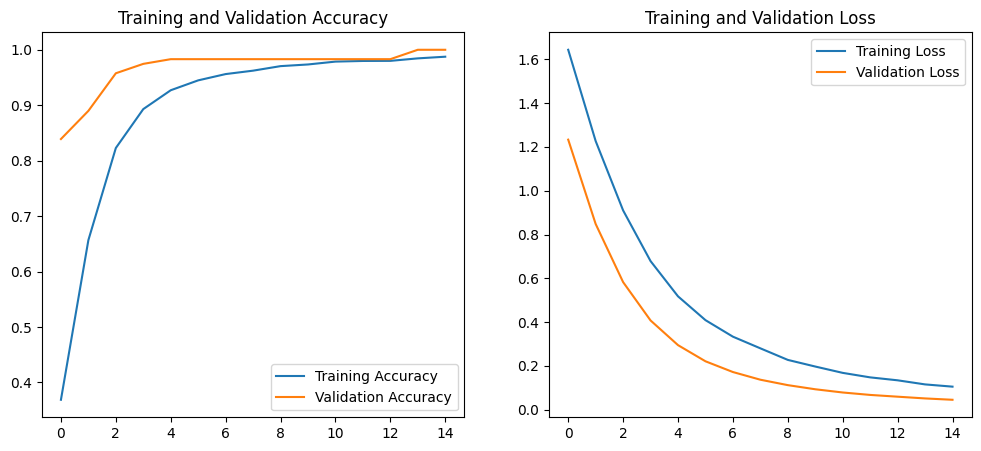

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

4/4 - 3s - 3s/epoch - 663ms/step


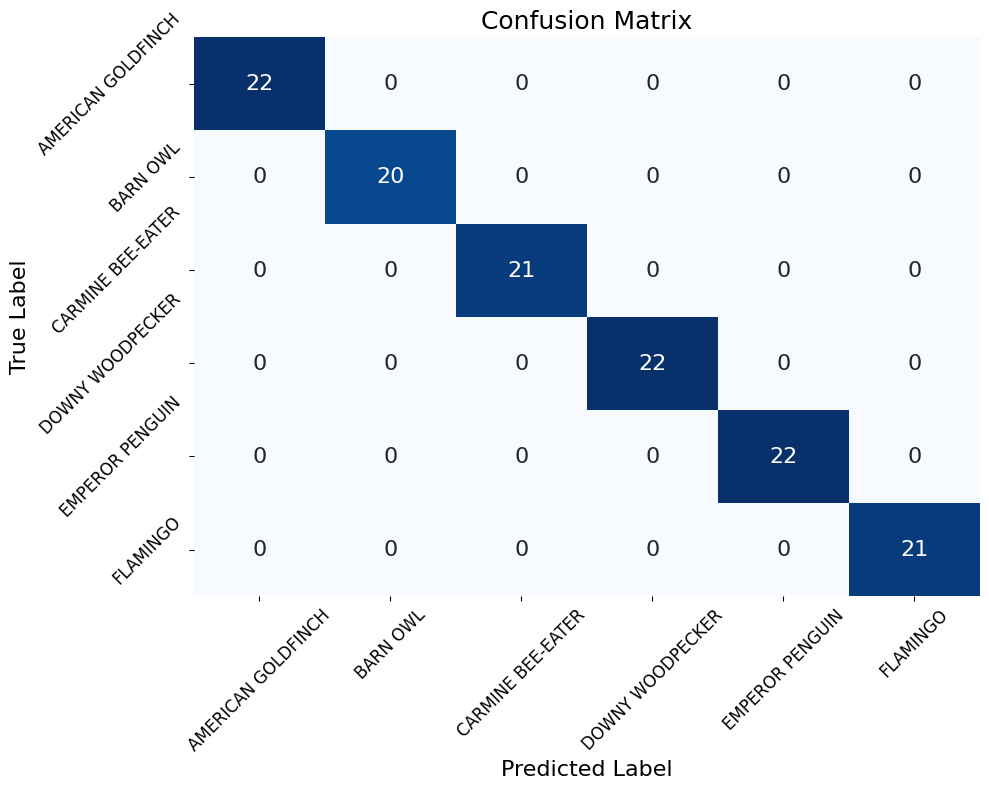

In [20]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_pred = model.predict(test_data, verbose=2)
test_pred_class = np.argmax(test_pred, axis=1)
test_true_class = test_data.classes
cm = confusion_matrix(test_true_class, test_pred_class)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys(), cbar=False, annot_kws={'size': 16})
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()



In [21]:
model.save("EfficientNetV2B0.h5")

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
